tb - Train coefficients of a simple analytic model for SW radiative transfer via stochastic gradient descent

Then calculate (1) Number of free parameters; and (2) error statistics of the net shortwave flux prediction (in $W m^{-2}$)

# Imports

In [4]:
from ml4rt.io.example_io import *
from ml4rt.utils.normalization import *
from ml4rt.machine_learning.neural_net import *
from ml4rt.machine_learning.u_net_architecture import *
from ml4rt.machine_learning.u_net_pp_architecture import *

import dill

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import seaborn as sns

import tensorflow as tf
from tensorflow import keras as K

In [5]:
fz = 15
lw = 4
siz = 100

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw

# Data Generator

## Loading model's metadata using dill

In [6]:
path_data = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/'

In [7]:
model_arc = dill.load(open(path_data+'actual_model/model_metadata.dill','rb'))

In [8]:
model_arc.keys()

dict_keys(['num_epochs', 'num_training_batches_per_epoch', 'training_option_dict', 'num_validation_batches_per_epoch', 'validation_option_dict', 'net_type_string', 'loss_function_or_dict', 'do_early_stopping', 'plateau_lr_multiplier'])

In [9]:
model_arc['net_type_string']

'u_net'

In [10]:
model_arc['validation_option_dict']

{'scalar_predictor_names': ['zenith_angle_radians', 'albedo'],
 'vector_predictor_names': ['pressure_pascals',
  'temperature_kelvins',
  'specific_humidity_kg_kg01',
  'liquid_water_content_kg_m03',
  'ice_water_content_kg_m03',
  'relative_humidity_unitless',
  'liquid_water_path_kg_m02',
  'ice_water_path_kg_m02',
  'vapour_path_kg_m02',
  'upward_liquid_water_path_kg_m02',
  'upward_ice_water_path_kg_m02',
  'upward_vapour_path_kg_m02'],
 'scalar_target_names': ['shortwave_surface_down_flux_w_m02',
  'shortwave_toa_up_flux_w_m02'],
 'vector_target_names': ['shortwave_heating_rate_k_day01'],
 'heights_m_agl': array([1.00e+01, 2.00e+01, 4.00e+01, 6.00e+01, 8.00e+01, 1.00e+02,
        1.20e+02, 1.40e+02, 1.60e+02, 1.80e+02, 2.00e+02, 2.25e+02,
        2.50e+02, 2.75e+02, 3.00e+02, 3.50e+02, 4.00e+02, 4.50e+02,
        5.00e+02, 6.00e+02, 7.00e+02, 8.00e+02, 9.00e+02, 1.00e+03,
        1.10e+03, 1.20e+03, 1.30e+03, 1.40e+03, 1.50e+03, 1.60e+03,
        1.70e+03, 1.80e+03, 1.90e+03, 2.0

In [27]:
model_arc['validation_option_dict']['example_dir_name'] = \
'/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites'

In [28]:
model_arc['validation_option_dict']['normalization_file_name'] = model_arc['validation_option_dict']['example_dir_name'] + \
'/learning_examples_20170101-20181224.nc'

tgb - 6/14/2022 - Train on 2018 non tropical sites for now

In [29]:
model_arc['validation_option_dict']['first_time_unix_sec'] = 1514764800 # Jan 1, 2018 at 12:00:00AM
model_arc['validation_option_dict']['last_time_unix_sec'] = 1546300799 # Dec 31, 2018 at 11:59:59PM

tgb - 6/14/2022 - Train on 2019/2020 non-tropical sites to test generalization ability, similar to experiment 1 of Ryan's paper

In [19]:
# model_arc['validation_option_dict']['first_time_unix_sec'] = 1546326000 # Jan 1, 2019 at 12:00:00AM
# model_arc['validation_option_dict']['last_time_unix_sec'] = 1577818799 # Dec 31, 2019 at 11:59:59PM

In [30]:
Unetpp_gen = data_generator(model_arc['validation_option_dict'],True,model_arc['net_type_string'])

In [31]:
Unetpp_data = create_data(model_arc['validation_option_dict'],True, 
                          model_arc['net_type_string'],exclude_summit_greenland=True)

Reading training examples (for normalization) from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_20170101-20181224.nc"...

Reading data from: "/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/learning_examples_2018.nc"...


/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/ml4rt/notebooks_tbeucler/ml4rt/io/example_io.py:304: UserWarning: Removing 0 of 898025 examples (profiles), because they are at Summit GL.
  warnings.warn(warning_string)


Applying Z_SCORE normalization to predictors...
Applying MINMAX normalization to scalar targets...


# Create small prototype using xarray

## Data loading and pre-processing

In [11]:
Nontrop_folder = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/non_tropical_sites/'
Trop_folder = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/2021_Ryan_Lagerquist_SW/tropical_sites/'

In [12]:
data2018 = xr.open_dataset(Nontrop_folder+'learning_examples_2018.nc')
data2019 = xr.open_dataset(Nontrop_folder+'learning_examples_2019.nc')
data2020 = xr.open_dataset(Nontrop_folder+'learning_examples_2020.nc')

trop2017 = xr.open_dataset(Trop_folder+'learning_examples_2017.nc')

## 2018 dataset

### Data analysis

In [14]:
data2018['vector_target_names']

<xarray.DataArray 'vector_target_names' (vector_target: 5)>
array([b'shortwave_down_flux_w_m02', b'shortwave_up_flux_w_m02',
       b'shortwave_heating_rate_k_day01',
       b'shortwave_down_flux_increment_w_m03',
       b'shortwave_up_flux_increment_w_m03'], dtype='|S35')
Dimensions without coordinates: vector_target

In [15]:
data2018['scalar_target_names']

<xarray.DataArray 'scalar_target_names' (scalar_target: 2)>
array([b'shortwave_surface_down_flux_w_m02', b'shortwave_toa_up_flux_w_m02'],
      dtype='|S35')
Dimensions without coordinates: scalar_target

In [16]:
data2018['scalar_predictor_names']

<xarray.DataArray 'scalar_predictor_names' (scalar_predictor: 6)>
array([b'zenith_angle_radians', b'albedo', b'latitude_deg_n',
       b'longitude_deg_e', b'column_liquid_water_path_kg_m02',
       b'column_ice_water_path_kg_m02'], dtype='|S35')
Dimensions without coordinates: scalar_predictor

In [92]:
data2019['vector_predictor_names']

<xarray.DataArray 'vector_predictor_names' (vector_predictor: 12)>
array([b'pressure_pascals', b'temperature_kelvins',
       b'specific_humidity_kg_kg01', b'liquid_water_content_kg_m03',
       b'ice_water_content_kg_m03', b'liquid_water_path_kg_m02',
       b'ice_water_path_kg_m02', b'vapour_path_kg_m02',
       b'upward_liquid_water_path_kg_m02', b'upward_ice_water_path_kg_m02',
       b'upward_vapour_path_kg_m02', b'relative_humidity_unitless'],
      dtype='|S35')
Dimensions without coordinates: vector_predictor

In [18]:
data2018['vector_predictor_matrix'].shape

(898025, 73, 12)

In [19]:
pload = data2018['vector_predictor_matrix'][:,:,0].values
pmean = np.mean(pload,axis=0)

In [20]:
data2018['scalar_target_matrix'].shape

(898025, 2)

Text(0.5, 0, 'TOA SW upwards flux (W/m2)')

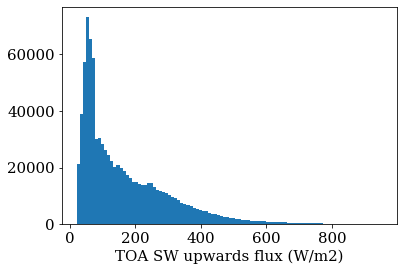

In [21]:
plt.hist(data2018['scalar_target_matrix'][:,1].values.flatten(),bins=100);
plt.xlabel('TOA SW upwards flux (W/m2)')

In [22]:
data2018['vector_target_matrix'].shape

(898025, 73, 5)

Text(0.5, 0, 'TOA SW downwards flux (W/m2)')

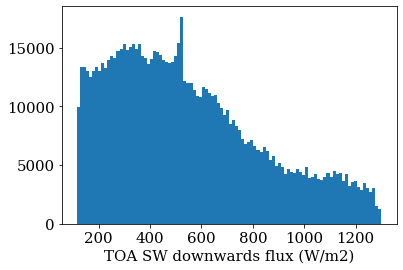

In [23]:
plt.hist(data2018['vector_target_matrix'][:,-1,0].values.flatten(),bins=100);
plt.xlabel('TOA SW downwards flux (W/m2)')

In [24]:
FSWnet_downwards = (data2018['vector_target_matrix'][:,:,0]-data2018['vector_target_matrix'][:,:,1]).values

In [25]:
FSWnet_downwards.shape

(898025, 73)

In [26]:
FSWnet_down_mean = np.mean(FSWnet_downwards,axis=0)
FSWnet_25 = np.percentile(a=FSWnet_downwards,q=25,axis=0)
FSWnet_75 = np.percentile(a=FSWnet_downwards,q=75,axis=0)
FSWnet_1 = np.percentile(a=FSWnet_downwards,q=1,axis=0)
FSWnet_99 = np.percentile(a=FSWnet_downwards,q=99,axis=0)

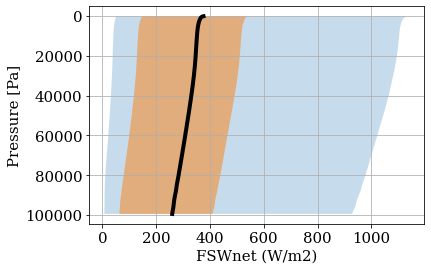

In [27]:
plt.plot(FSWnet_down_mean,pmean,color='k')
plt.fill_betweenx(y=pmean,x1=FSWnet_1,x2=FSWnet_99,alpha=0.25)
plt.fill_betweenx(y=pmean,x1=FSWnet_25,x2=FSWnet_75,alpha=0.5)
plt.gca().invert_yaxis()
plt.grid()
plt.xlabel('FSWnet (W/m2)');
plt.ylabel('Pressure [Pa]');

Text(0.5, 0, 'Fnet/(Fnet at TOA)')

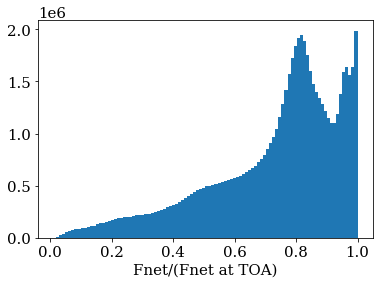

In [28]:
plt.hist((FSWnet_downwards/np.expand_dims(FSWnet_downwards[:,-1],axis=1)).flatten(),bins=100);
plt.xlabel('Fnet/(Fnet at TOA)')

x = [Fnet_top,zenith_angle,p,qv,ql,qi] of length 294  
y = [Fnet] of length 72

In [29]:
zen_angle = data2018['scalar_predictor_matrix'][:,0].values

Text(0.5, 0, 'Zenith Angle (rad)')

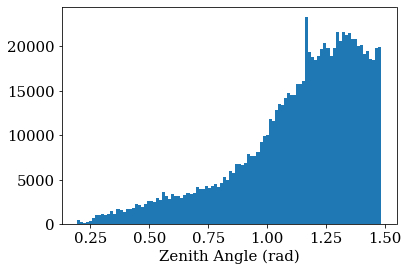

In [30]:
plt.hist(zen_angle.flatten(),bins=100)
plt.xlabel('Zenith Angle (rad)')

In [31]:
pload.shape

(898025, 73)

In [32]:
qvload = data2018['vector_predictor_matrix'][:,:,2].values
qlload = data2018['vector_predictor_matrix'][:,:,3].values
qiload = data2018['vector_predictor_matrix'][:,:,4].values

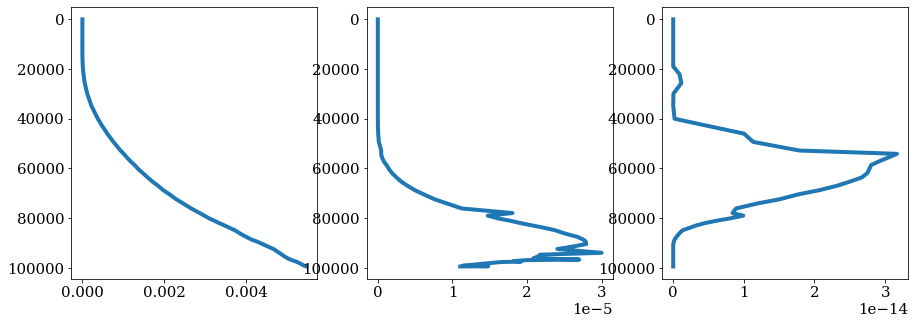

In [33]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].plot(np.mean(qvload,axis=0),pmean)
ax[0].invert_yaxis()

ax[1].plot(np.mean(qlload,axis=0),pmean)
ax[1].invert_yaxis()

ax[2].plot(np.mean(qiload,axis=0),pmean)
ax[2].invert_yaxis()

(0.0, 100.0)

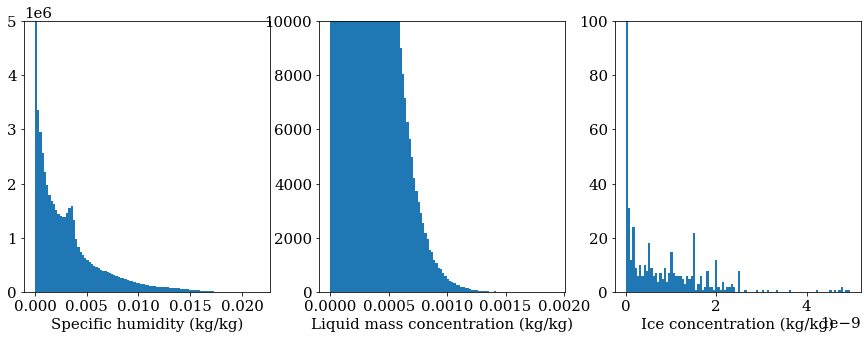

In [34]:
fig,ax = plt.subplots(1,3,figsize=(15,5))

ax[0].hist(qvload.flatten(),bins=100)
ax[0].set_xlabel('Specific humidity (kg/kg)')
ax[0].set_ylim((0,5e6))

ax[1].hist(qlload.flatten(),bins=100)
ax[1].set_xlabel('Liquid mass concentration (kg/kg)')
ax[1].set_ylim((0,1e4))

ax[2].hist(qiload.flatten(),bins=100)
ax[2].set_xlabel('Ice concentration (kg/kg)')
ax[2].set_ylim((0,1e2))

x = [Fnet_top,zenith_angle,p,qv,ql,qi] of length 294  
y = [Fnet] of length 72

In [35]:
x = np.concatenate((
    np.expand_dims(FSWnet_downwards[:,-1],axis=1),
    np.expand_dims(zen_angle,axis=1),
    pload,
    qvload,
    qlload,
    qiload),
    axis=1
)

In [36]:
x.shape

(898025, 294)

In [37]:
y = FSWnet_downwards[:,]

In [38]:
y.shape

(898025, 73)

### Calculate median/std of qv/ql/qi to normalize them before the two-stream model

In [39]:
x_mean = np.mean(x,axis=0)

In [40]:
x_std = np.std(x,axis=0)

In [41]:
x_normalized = (x-x_mean)/x_std

/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/miniconda3/envs/ml4rt/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/miniconda3/envs/ml4rt/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/miniconda3/envs/ml4rt/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


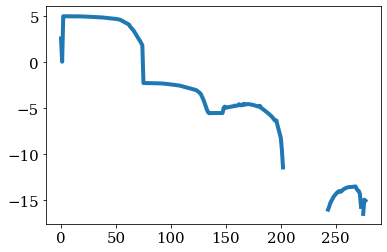

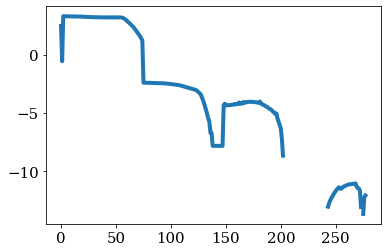

In [42]:
plt.plot(np.log10(x_mean))
plt.figure()
plt.plot(np.log10(x_std))

In [43]:
x_std_filled = np.copy(x_std)
x_std_filled[x_std_filled==0] = 1

Full Z-score normalization

In [44]:
x_normalized = (x-x_mean)/x_std_filled

Normalize only water species (for optical thickness calculations), with one normalization set per variable (to maintain vertical profile), and leave the rest as is

`x = [Fnet_top,zenith_angle,p,qv,ql,qi]` of length 294  
`y = [Fnet]` of length 72

In [67]:
QV_i = slice(75,148)
QL_i = slice(148,221)
QI_i = slice(221,294)

In [68]:
x_mean_qv = np.mean(x[:,QV_i],axis=(0,1))
x_mean_ql = np.mean(x[:,QL_i],axis=(0,1))
x_mean_qi = np.mean(x[:,QI_i],axis=(0,1))
print(x_mean_qv,x_mean_ql,x_mean_qi)

0.0025044703 9.973105e-06 5.6954034e-15


In [69]:
x_std_qv = np.max(np.std(x[:,QV_i],axis=0))
x_std_ql = np.max(np.std(x[:,QL_i],axis=0))
x_std_qi = np.max(np.std(x[:,QI_i],axis=0))
print(x_std_qv,x_std_ql,x_std_qi)

0.003874701 9.44847e-05 9.1013655e-12


In [70]:
qv_norm = (x[:,QV_i]-x_mean_qv)/x_std_qv
ql_norm = (x[:,QL_i]-x_mean_ql)/x_std_ql
qi_norm = (x[:,QI_i]-x_mean_qi)/x_std_qi

In [71]:
x_normalized = np.concatenate(
    (x[:,:75],
    qv_norm,
    ql_norm,
    qi_norm),
    axis=1
)

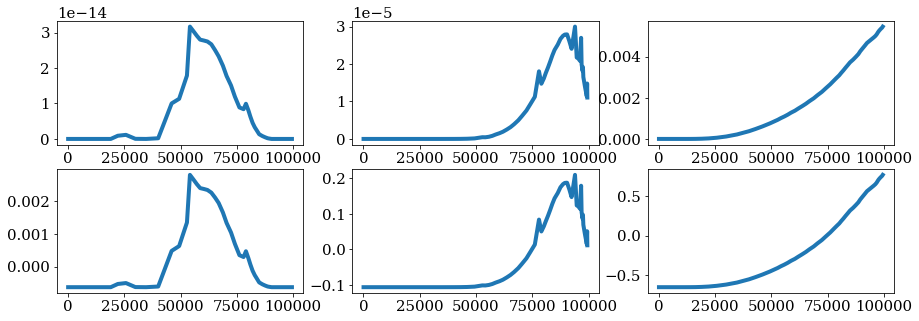

In [72]:
fig,ax = plt.subplots(2,3,figsize=(15,5))

ax[0,0].plot(pmean,np.mean(x[:,QI_i],axis=0))
ax[1,0].plot(pmean,np.mean(x_normalized[:,QI_i],axis=0))

ax[0,1].plot(pmean,np.mean(x[:,QL_i],axis=0))
ax[1,1].plot(pmean,np.mean(x_normalized[:,QL_i],axis=0))

ax[0,2].plot(pmean,np.mean(x[:,QV_i],axis=0))
ax[1,2].plot(pmean,np.mean(x_normalized[:,QV_i],axis=0))

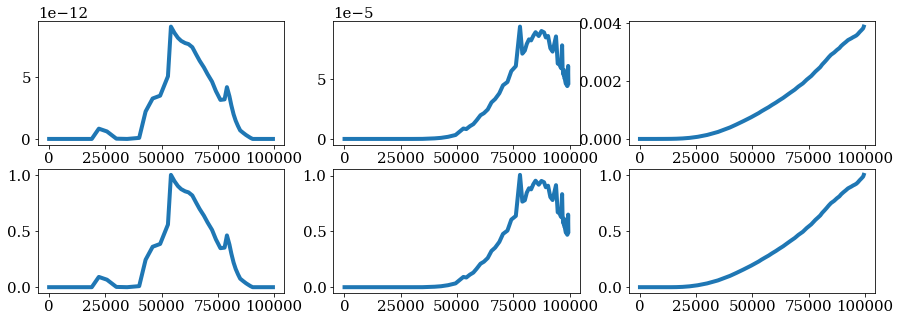

In [73]:
fig,ax = plt.subplots(2,3,figsize=(15,5))

ax[0,0].plot(pmean,np.std(x[:,QI_i],axis=0))
ax[1,0].plot(pmean,np.std(x_normalized[:,QI_i],axis=0))

ax[0,1].plot(pmean,np.std(x[:,QL_i],axis=0))
ax[1,1].plot(pmean,np.std(x_normalized[:,QL_i],axis=0))

ax[0,2].plot(pmean,np.std(x[:,QV_i],axis=0))
ax[1,2].plot(pmean,np.std(x_normalized[:,QV_i],axis=0))

## 2019-2020 non-tropical dataset

In [13]:
data2019['vector_predictor_names']

<xarray.DataArray 'vector_predictor_names' (vector_predictor: 12)>
array([b'pressure_pascals', b'temperature_kelvins',
       b'specific_humidity_kg_kg01', b'liquid_water_content_kg_m03',
       b'ice_water_content_kg_m03', b'liquid_water_path_kg_m02',
       b'ice_water_path_kg_m02', b'vapour_path_kg_m02',
       b'upward_liquid_water_path_kg_m02', b'upward_ice_water_path_kg_m02',
       b'upward_vapour_path_kg_m02', b'relative_humidity_unitless'],
      dtype='|S35')
Dimensions without coordinates: vector_predictor

In [14]:
pload2019 = data2019['vector_predictor_matrix'][:,:,0].values
pload2020 = data2020['vector_predictor_matrix'][:,:,0].values
pload = np.concatenate((pload2019,pload2020),axis=0)

In [15]:
FSWnet2019_downwards = (data2019['vector_target_matrix'][:,:,0]-data2019['vector_target_matrix'][:,:,1]).values
FSWnet2020_downwards = (data2020['vector_target_matrix'][:,:,0]-data2020['vector_target_matrix'][:,:,1]).values
FSWnet_downwards = np.concatenate((FSWnet2019_downwards,FSWnet2020_downwards),axis=0)

In [16]:
zen_angle2019 = data2019['scalar_predictor_matrix'][:,0].values
zen_angle2020 = data2020['scalar_predictor_matrix'][:,0].values
zen_angle = np.concatenate((zen_angle2019,zen_angle2020),axis=0)

In [17]:
QVup2019 = data2019['vector_predictor_matrix'][:,:,7].values
QVup2020 = data2020['vector_predictor_matrix'][:,:,7].values
QVup = np.concatenate((QVup2019,QVup2020),axis=0)

In [18]:
QLup2019 = data2019['vector_predictor_matrix'][:,:,5].values
QLup2020 = data2020['vector_predictor_matrix'][:,:,5].values
QLup = np.concatenate((QLup2019,QLup2020),axis=0)

In [19]:
pload.shape

(1499097, 73)

In [20]:
pload2019.shape

(964823, 73)

In [21]:
x201920 = \
np.concatenate((
    np.expand_dims(FSWnet_downwards[:,-1],axis=1),
    np.expand_dims(zen_angle,axis=1),
    QVup,
    QLup),
    axis=1
)

In [22]:
y201920 = FSWnet_downwards
y201920.shape

(1499097, 73)

In [23]:
x201920.shape # dim 1: 2+3*73

(1499097, 148)

In [24]:
QV_i = slice(2,2+73)
QL_i = slice(2+73,2+2*73)
QI_i = slice(2+2*73,2+3*73)

## 2017 Tropical test set

In [25]:
pload2017 = trop2017['vector_predictor_matrix'][:,:,0].values
FSWnet2017_downwards = (trop2017['vector_target_matrix'][:,:,0]-trop2017['vector_target_matrix'][:,:,1]).values
zen_angle2017 = trop2017['scalar_predictor_matrix'][:,0].values
QVup2017 = trop2017['vector_predictor_matrix'][:,:,7].values
QLup2017 = trop2017['vector_predictor_matrix'][:,:,5].values

In [26]:
x2017 = \
np.concatenate((
    np.expand_dims(FSWnet2017_downwards[:,-1],axis=1),
    np.expand_dims(zen_angle2017,axis=1),
    QVup2017,
    QLup2017),
    axis=1
)

y2017 = FSWnet2017_downwards
y201920.shape

(1499097, 73)

## Create simple scipy optimize model

In [27]:
def MSE(kappa,ypred,ytrue):
    return np.mean((ypred-ytrue)**2,axis=(0,1))

In [28]:
def prediction(x,kappa):
    
    QV_i = slice(2,2+73)
    QL_i = slice(2+73,2+2*73)
    
    tau = kappa[0]+kappa[1]*x[:,QV_i]+1e3*kappa[2]*x[:,QL_i]
    return x[:,0:1]*np.exp(-tau/(np.cos(x[:,1:2])))

In [29]:
def residuals(kappa,x,y):
    
    QV_i = slice(2,2+73)
    QL_i = slice(2+73,2+2*73)
    
    tau = kappa[0]+kappa[1]*x[:,QV_i]+1e3*kappa[2]*x[:,QL_i]
    ypred = x[:,0:1]*np.exp(-tau/(np.cos(x[:,1:2])))
    
    return (y-ypred).flatten()

In [222]:
kappa_guess = [0,1e-2,1e-2]

In [219]:
ytest = prediction(x201920[:1000,:],kappa_guess)

In [223]:
resid = residuals(kappa_guess,x201920[:1000,:],y201920[:1000,:])

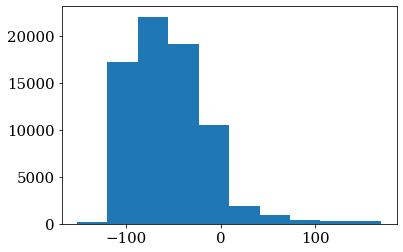

In [226]:
plt.hist(resid.flatten(),bins=10);

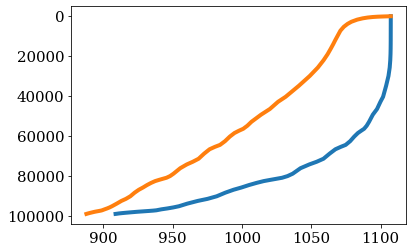

In [220]:
plt.plot(np.mean(ytest,axis=0),np.mean(pload,axis=0))
plt.gca().invert_yaxis()
plt.plot(np.mean(y201920[:1000,:],axis=0),np.mean(pload,axis=0))

In [251]:
N_samples = 1000000

In [252]:
LS = scipy.optimize.least_squares(residuals,kappa_guess,args=(x201920[:N_samples,:],y201920[:N_samples,:]))
print(LS)

 active_mask: array([0., 0., 0.])
        cost: 38846152704.0
         fun: array([-56.700806, -56.892456, -56.96997 , ...,  55.287933,  57.15619 ,
        59.374084], dtype=float32)
        grad: array([-2753569.19505426,  4350375.14110222,  3856146.164166  ])
         jac: array([[9.94192139e+02, 1.60811992e+04, 0.00000000e+00],
       [9.94722473e+02, 1.59882148e+04, 0.00000000e+00],
       [9.95606384e+02, 1.58489150e+04, 0.00000000e+00],
       ...,
       [1.04236377e+03, 8.83883461e-02, 0.00000000e+00],
       [1.04245215e+03, 0.00000000e+00, 0.00000000e+00],
       [1.04236377e+03, 0.00000000e+00, 0.00000000e+00]])
     message: '`xtol` termination condition is satisfied.'
        nfev: 14
        njev: 8
  optimality: 4350375.141102225
      status: 3
     success: True
           x: array([0.05188049, 0.00592465, 0.00346496])


In [253]:
kappa_LS = LS.x

In [254]:
ytest = prediction(x201920[:N_samples,:],kappa_LS)

In [255]:
np.mean((ytest-y201920[:N_samples,:])**2)

1066.4026

## Create custom keras/tf model

### Version only using upward vapor/liquid path

In [30]:
class One_Stream_RT(tf.keras.layers.Layer):
    """y = sum(w.q) + b"""

    def __init__(self, input_dim=73, **kwargs):
        super(One_Stream_RT, self).__init__()
        # Assign attributes
        self.input_dim = np.array(input_dim)
        # Random weights initialization and definition for absorption
        k_init = tf.zeros_initializer()
        self.k = tf.Variable(
            initial_value=k_init(shape=(3,), dtype="float32"),
            trainable=True,
            constraint=lambda z: tf.clip_by_value(z, 0, np.infty),
            name='k'
        )
        # Hardcode indices for now
        self.F_TOA = 0
        self.zen_ang_i = 1
        self.QV_i = slice(2,2+73)
        self.QL_i = slice(2+73,2+2*73)
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)
    
    def get_config(self):
        config = {'input_dim': self.input_dim}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        
        inp = arrs[0]
        
        # 1. Extract variables separately
        F_TOA = inp[:,self.F_TOA]
        QV = inp[:,self.QV_i]
        QL = inp[:,self.QL_i]
        za = inp[:,self.zen_ang_i]
        
        # 2. One-stream SW radiation model
        absorb = self.k[0]+self.k[1]*QV+self.k[2]*1e3*QL
        F = F_TOA[:,None]*tf.math.exp(-absorb/tf.math.cos(za[:,None]))
        
        return F

    def compute_output_shape(self, input_shape):
        "It's a simple sum at each level so shape 73"
        return (input_shape[0][0], 73)

### Version integrating the full profile of vapor/liquid water

In [45]:
class Absorb_Layer(tf.keras.layers.Layer):
    """y = sum(w.q) + b"""

    def __init__(self, input_dim=73, fac_qv=1, fac_ql=1, fac_qi=1, **kwargs):
        super(Absorb_Layer, self).__init__()
        # Assign attributes
        self.input_dim, self.fac_qv, self.fac_ql, self.fac_qi = \
        np.array(input_dim), np.array(fac_qv), np.array(fac_ql), np.array(fac_qi)
        # Random weights initialization and definition for absorption
        k_init = tf.zeros_initializer()
        self.k = tf.Variable(
            initial_value=k_init(shape=(3,), dtype="float32"),
            trainable=True,
            constraint=lambda z: tf.clip_by_value(z, 0, np.infty),
            name='k'
        )
        k0_init = tf.zeros_initializer()
        self.k0 = tf.Variable(
            initial_value=k0_init(shape=(1,), dtype="float32"), trainable=True,
            constraint=lambda z: tf.clip_by_value(z, 0, np.infty),
            name='k0'
        )
        # Hardcode indices for now
        self.QV_i = slice(75,148)
        self.QL_i = slice(148,221)
        self.QI_i = slice(221,294)
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)
    
    def get_config(self):
        config = {'input_dim': self.input_dim, 
                  'fac_qv': self.fac_qv,
                  'fac_ql': self.fac_ql, 
                  'fac_qi': self.fac_qi}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        
        inp = arrs[0]
        
        # 1. Extract QV/QL/QI separately
        qv = inp[:,self.QV_i]
        ql = inp[:,self.QL_i]
        qi = inp[:,self.QI_i]

        # 2. Multiply each one by individual weight and sum it all
        absorb = self.k[0]*self.fac_qv*qv + self.k[1]*self.fac_ql*ql + \
        self.k[2]*self.fac_qi*qi + self.k0 
        
        return absorb

    def compute_output_shape(self, input_shape):
        "It's a simple sum at each level so shape 73"
        return (input_shape[0][0], 73)

In [46]:
class Optical_Thickness(tf.keras.layers.Layer):
    """y = sum(w.q) + b"""

    def __init__(self, input_dim=73, epsilon=1e-2, **kwargs):
        super(Optical_Thickness, self).__init__()
        # Assign attributes
        self.input_dim, self.epsilon = \
        np.array(input_dim), np.array(np.float32(epsilon))
        
        # Hardcode indices for now
        self.zen_ang_i = 1
        self.P_i = slice(2,75)
        self.PS_i = 2
        self.D = 1
        self.G = 9.81
        self.dPend = slice(0,72)
        self.dPbeg = slice(1,73)
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)
        
    def get_config(self):
        config = {'input_dim': self.input_dim, 
                  'epsilon': self.epsilon}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        
        inp,absorb = arrs
        
        # 1. Extract P, PS, and zenith angle
        p = inp[:,self.P_i]
        ps = inp[:,self.PS_i]
        za = inp[:,self.zen_ang_i]
        pb = absorb/(self.G*\
                     tf.math.maximum(self.epsilon,tf.math.cos(za[:,None])))
        
        # 4. Vertically integrate from top (last index) to level p
        dP = p[:,self.dPend] - p[:,self.dPbeg]
        integrand = 0.5*(pb[:,self.dPend] + pb[:,self.dPbeg])
        integrand = tf.reverse(integrand,axis=[1])
        integral = tf.math.cumsum(integrand,axis=1)
        integral = tf.reverse(integral,axis=[1])
        integral = tf.concat([integral,0*ps[:,None]],axis=1)
        
        return integral

    def compute_output_shape(self, input_shape):
        "It's a simple sum at each level so shape 73"
        return (input_shape[0][0], 73)

In [47]:
class Absorb_Flux(tf.keras.layers.Layer):
    """y = sum(w.q) + b"""

    def __init__(self, input_dim=73,**kwargs):
        super(Absorb_Flux, self).__init__()
        # Attributes
        self.input_dim = input_dim
        # Hardcode indices for now
        self.F_TOA = 0
        super().__init__(**kwargs)
    
    def build(self, input_shape):
        super().build(input_shape)
        
    def get_config(self):
        config = {'input_dim': self.input_dim}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))
    
    def call(self, arrs):
        
        inp,optthi = arrs
        
        # 1. Take exponential
        decay = tf.math.exp(-optthi)
        
        # 2. Extract TOA flux
        F_TOA = inp[:,self.F_TOA]
        
        # 2. Multiply by TOA flux
        fnet = decay*F_TOA[:,None]
        
        return fnet

    def compute_output_shape(self, input_shape):
        "It's a simple sum at each level so shape 73"
        return (input_shape[0][0], 73)

## Train model

### Version directly taking upward vapor/liquid paths

In [31]:
inp = K.Input(shape=(148,))
flux = One_Stream_RT()([inp])
model = tf.keras.models.Model(inp,flux)

2022-06-15 00:38:51.433370: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-06-15 00:38:51.452111: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2894740000 Hz
2022-06-15 00:38:51.454639: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x556d9cdff390 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-06-15 00:38:51.454686: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-06-15 00:38:51.454837: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [32]:
Adam_lrM5 = tf.keras.optimizers.Adam(
    learning_rate=1e-6,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

In [33]:
model.compile(optimizer=Adam_lrM5,loss='mse')

In [34]:
history = model.fit(x201920,y201920,epochs=20,batch_size=128)

Epoch 1/20
11712/11712 [==============================] - 26s 2ms/step - loss: 3299.9260
Epoch 2/20
11712/11712 [==============================] - 24s 2ms/step - loss: 1546.7574
Epoch 3/20
11712/11712 [==============================] - 27s 2ms/step - loss: 1301.4312
Epoch 4/20
11712/11712 [==============================] - 25s 2ms/step - loss: 1152.1024
Epoch 5/20
11712/11712 [==============================] - 24s 2ms/step - loss: 1087.3838
Epoch 6/20
11712/11712 [==============================] - 25s 2ms/step - loss: 1076.8837
Epoch 7/20
11712/11712 [==============================] - 24s 2ms/step - loss: 1076.6898
Epoch 8/20
11712/11712 [==============================] - 26s 2ms/step - loss: 1076.6857
Epoch 9/20
11712/11712 [==============================] - 24s 2ms/step - loss: 1076.6855
Epoch 10/20
11712/11712 [==============================] - 26s 2ms/step - loss: 1076.6885
Epoch 11/20
11712/11712 [==============================] - 25s 2ms/step - loss: 1076.6854
Epoch 12/20
11712/1

In [35]:
model.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([0.05319668, 0.00607786, 0.00352458], dtype=float32)>]

### Version integrating the full vertical profile of water vapor

In [48]:
inp = K.Input(shape=(294,))
absorb = Absorb_Layer()([inp])
optthi = Optical_Thickness()([inp,absorb])
flux = Absorb_Flux()([inp,optthi])
model = tf.keras.models.Model(inp,flux)

2022-03-07 21:39:46.488842: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2022-03-07 21:39:46.948947: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2894395000 Hz
2022-03-07 21:39:46.952088: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x55f0607762c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-03-07 21:39:46.952163: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2022-03-07 21:39:46.967010: I tensorflow/core/common_runtime/process_util.cc:147] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [49]:
Adam_lrM5 = tf.keras.optimizers.Adam(
    learning_rate=1e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

In [50]:
model.compile(optimizer=Adam_lrM5,loss='mse')

In [125]:
#history = model.fit(x_normalized,y,epochs=20,batch_size=128)

Epoch 1/20
7016/7016 [==============================] - 8s 1ms/step - loss: 2443.2288
Epoch 2/20
7016/7016 [==============================] - 8s 1ms/step - loss: 1164.3871
Epoch 3/20
7016/7016 [==============================] - 8s 1ms/step - loss: 1009.8867
Epoch 4/20
7016/7016 [==============================] - 8s 1ms/step - loss: 947.5882
Epoch 5/20
7016/7016 [==============================] - 8s 1ms/step - loss: 924.5251
Epoch 6/20
7016/7016 [==============================] - 8s 1ms/step - loss: 915.7813
Epoch 7/20
7016/7016 [==============================] - 8s 1ms/step - loss: 912.1648
Epoch 8/20
7016/7016 [==============================] - 8s 1ms/step - loss: 910.5569
Epoch 9/20
7016/7016 [==============================] - 8s 1ms/step - loss: 909.8109
Epoch 10/20
7016/7016 [==============================] - 8s 1ms/step - loss: 909.4550
Epoch 11/20
7016/7016 [==============================] - 8s 1ms/step - loss: 909.2808
Epoch 12/20
7016/7016 [==============================] - 8s 

In [51]:
path_HDF5 = '/work/FAC/FGSE/IDYST/tbeucler/default/tbeucler/HDF5_DATA/ml4rt/'

In [52]:
#model.save(path_HDF5+'2022_03_07_SW_abs.hdf5')

In [53]:
dict_lay = {'Absorb_Layer':Absorb_Layer,'Optical_Thickness':Optical_Thickness,'Absorb_Flux':Absorb_Flux}

In [54]:
model.load_weights(path_HDF5+'2022_03_07_SW_abs.hdf5')

In [56]:
inp2 = K.Input(shape=(294,))
absorb = Absorb_Layer(fac_qv=1e3, fac_ql=1e6, fac_qi=1e6)([inp2])
optthi = Optical_Thickness()([inp2,absorb])
flux2 = Absorb_Flux()([inp2,optthi])
model2 = tf.keras.models.Model(inp2,flux2)

In [57]:
model2.load_weights(path_HDF5+'2021_10_21_SW_abs.hdf5')

In [58]:
#model = K.models.load_model(path_HDF5+'2021_10_21_SW_abs.hdf5',custom_objects=dict_lay)

In [59]:
model.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([4.6624602e-03, 2.5871807e-01, 2.7388674e-07], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.05137667], dtype=float32)>]

In [60]:
model2.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([0.00116458, 0.00286141, 0.00107097], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.02102046], dtype=float32)>]

Overall predictions

In [74]:
F_pred = model.predict(x_normalized)

In [62]:
F_pred2 = model.predict(x)

Text(0.5, 1.0, 'Simple absorption model')

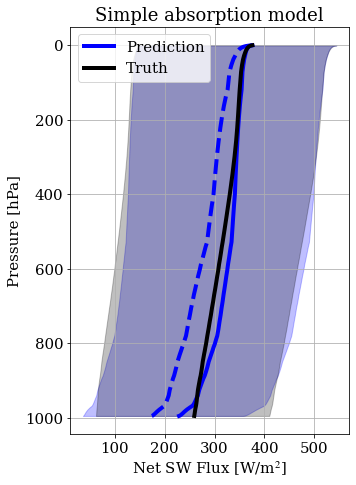

In [77]:
plt.figure(figsize=(5,7.5))

plt.plot(np.mean(F_pred,axis=0),pmean/100,color='b',label='Prediction')
plt.plot(np.mean(F_pred2,axis=0),pmean/100,color='b',linestyle='--')
plt.plot(np.mean(y,axis=0),pmean/100,color='k',label='Truth')

# plt.plot(np.percentile(a=F_pred,q=25,axis=0),pmean/100,color='b',linestyle='--')
# plt.plot(np.percentile(a=y,q=25,axis=0),pmean/100,color='k',linestyle='--')

# plt.plot(np.percentile(a=F_pred,q=75,axis=0),pmean/100,color='b',linestyle='--')
# plt.plot(np.percentile(a=y,q=75,axis=0),pmean/100,color='k',linestyle='--')

plt.fill_betweenx(y=pmean/100,
                  x1=np.percentile(a=F_pred,q=25,axis=0),
                  x2=np.percentile(a=F_pred,q=75,axis=0),
                  alpha=0.25,color='b')
plt.fill_betweenx(y=pmean/100,
                  x1=np.percentile(a=y,q=25,axis=0),
                  x2=np.percentile(a=y,q=75,axis=0),
                  alpha=0.25,color='k')

plt.gca().invert_yaxis()
plt.legend()
plt.grid()
plt.xlabel('Net SW Flux [W/m$^{2}$]')
plt.ylabel('Pressure [hPa]')
plt.title('Simple absorption model')

In [78]:
np.mean((F_pred-y)**2)

909.08466

In [79]:
np.mean((F_pred2-y)**2)

5256.104

In [80]:
np.mean((y-np.mean(y,axis=0))**2)

69123.625

In [81]:
np.mean(y**2)

162273.44

In [82]:
y_min = np.min(y)

In [83]:
y_max = np.max(y)

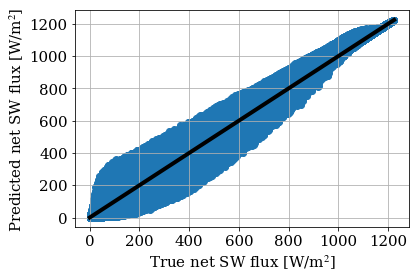

In [84]:
plt.scatter(y.flatten(),F_pred.flatten())
y_plot = np.linspace(y_min,y_max,100)
plt.plot(y_plot,y_plot,color='k')
plt.xlabel('True net SW flux [W/m${^2}$]')
plt.ylabel('Predicted net SW flux [W/m${^2}$]')
plt.grid()

In [85]:
#sns.jointplot(x=y.flatten(), y=F_pred.flatten(), kind="kde")

Predictions as a function of zenith angle

x = [Fnet_top,zenith_angle,p,qv,ql,qi] of length 294  
y = [Fnet] of length 72

In [86]:
# From https://stackoverflow.com/questions/2413522/weighted-standard-deviation-in-np
def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.
    values, weights -- np ndarrays with the same shape.
    """
    if np.sum(weights)>0:
        average = np.average(values, weights=weights)
        variance = np.average((values-average)**2, weights=weights)
    else:
        average = np.nan
        variance = np.nan
    return (average, np.sqrt(variance))

# Make function to calculate conditional mean and std
# We condition field_y on field_x
def conditional_avg_and_std(bin_edges,field_x,field_y):
    # Initialization
    Nbin = np.size(bin_edges)
    Ym = np.zeros((Nbin-1,1))
    Ystd = np.copy(Ym)

    for ibin,edge in enumerate(bin_edges):
        print('ibin=',ibin,'/',Nbin-1,' & edge=',edge,end="\r")
        if ibin>0:
            w = (field_x>=edge_left)*(field_x<edge)
            Ym[ibin-1],Ystd[ibin-1] = weighted_avg_and_std(field_y,w)

        edge_left = edge
    
    return Ym,Ystd

See if zenith angle used appropriately

In [87]:
his_za = np.histogram(x[:,1].flatten(),bins=100)

In [88]:
Y_av = conditional_avg_and_std(his_za[1],x[:,1],y[:,0])

In [89]:
Ypred_av = conditional_avg_and_std(his_za[1],x[:,1],F_pred[:,0])

In [90]:
Y_S0_av = conditional_avg_and_std(his_za[1],x[:,1],y[:,0]/x[:,0])
Ypred_S0_av = conditional_avg_and_std(his_za[1],x[:,1],F_pred[:,0]/x[:,0])

In [91]:
# From edges to middle of bins
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

Text(0.5, 1.0, 'Conditional average')

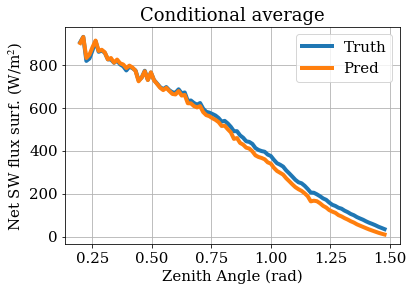

In [92]:
plt.plot(edgTObin(his_za[1]),Y_av[0],label='Truth')
plt.plot(edgTObin(his_za[1]),Ypred_av[0],label='Pred')
plt.grid()
plt.legend()
plt.xlabel('Zenith Angle (rad)')
plt.ylabel('Net SW flux surf. (W/m$^{2}$)')
plt.title('Conditional average')

Text(0.5, 1.0, 'Net SW flux / TOA flux')

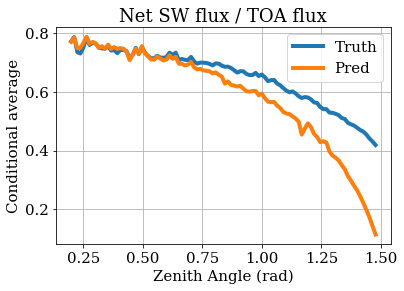

In [93]:
plt.plot(edgTObin(his_za[1]),Y_S0_av[0],label='Truth')
plt.plot(edgTObin(his_za[1]),Ypred_S0_av[0],label='Pred')
plt.grid()
plt.legend()
plt.xlabel('Zenith Angle (rad)')
plt.ylabel('Conditional average')
plt.title('Net SW flux / TOA flux')

Decomposing predictions

In [94]:
inp = K.Input(shape=(294,))
absorb = Absorb_Layer()([inp])
# optthi = Optical_Thickness()([inp,absorb])
# flux = Absorb_Flux()([inp,optthi])
model1 = tf.keras.models.Model(inp,absorb)

In [95]:
model1.compile(optimizer='Adam',loss='mse')

In [96]:
model1.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [97]:
model1.weights[0].assign(model.weights[0])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([4.6624602e-03, 2.5871807e-01, 2.7388674e-07], dtype=float32)>

In [98]:
model1.weights[1].assign(model.weights[1])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.05137667], dtype=float32)>

In [99]:
model1.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([4.6624602e-03, 2.5871807e-01, 2.7388674e-07], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.05137667], dtype=float32)>]

In [100]:
absorb_test = model1.predict(x)

In [101]:
absorb_test.shape

(898025, 73)

Text(0, 0.5, 'Pressure [Pa]')

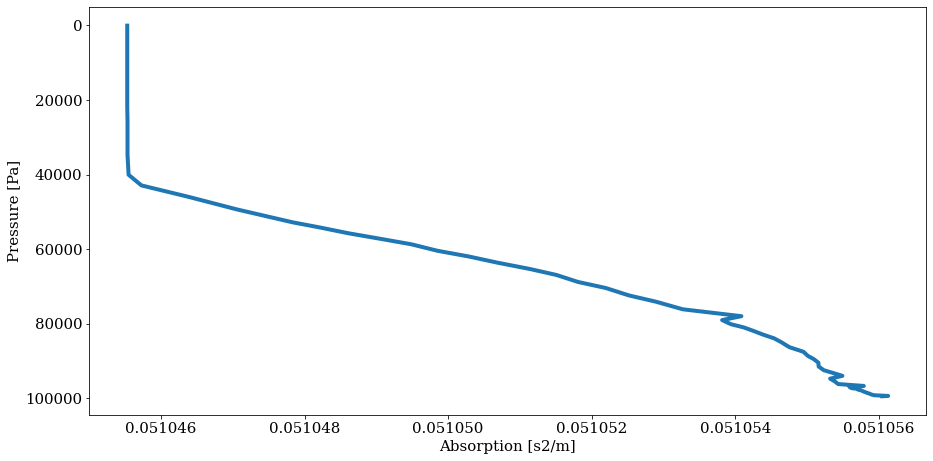

In [112]:
plt.figure(figsize=(15,7.5))

plt.plot(np.mean(absorb_test,axis=0),pmean)
plt.gca().invert_yaxis()
plt.xlabel('Absorption [s2/m]')
plt.ylabel('Pressure [Pa]')

In [103]:
inp = K.Input(shape=(294,))
absorb = Absorb_Layer()([inp])
optthi = Optical_Thickness()([inp,absorb])
# flux = Absorb_Flux()([inp,optthi])
model2 = tf.keras.models.Model(inp,optthi)

In [104]:
model2.compile(optimizer='Adam',loss='mse')

In [105]:
model2.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [106]:
model2.weights[0].assign(model.weights[0])

<tf.Variable 'UnreadVariable' shape=(3,) dtype=float32, numpy=array([4.6624602e-03, 2.5871807e-01, 2.7388674e-07], dtype=float32)>

In [107]:
model2.weights[1].assign(model.weights[1])

<tf.Variable 'UnreadVariable' shape=(1,) dtype=float32, numpy=array([0.05137667], dtype=float32)>

In [108]:
# model2.weights[2].assign(model.weights[2])
# model2.weights[3].assign(model.weights[3])

In [109]:
model2.weights

[<tf.Variable 'k:0' shape=(3,) dtype=float32, numpy=array([4.6624602e-03, 2.5871807e-01, 2.7388674e-07], dtype=float32)>,
 <tf.Variable 'k0:0' shape=(1,) dtype=float32, numpy=array([0.05137667], dtype=float32)>]

In [110]:
optT_test = model2.predict(x)

optT_test.shape

(898025, 73)

Text(0, 0.5, 'Pressure [Pa]')

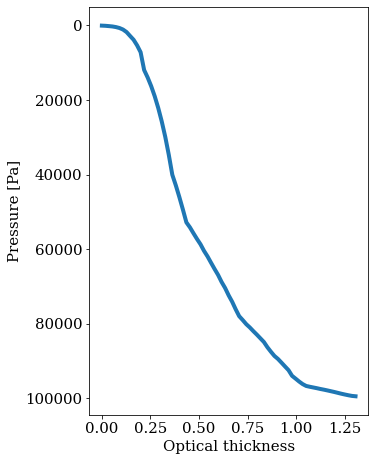

In [111]:
plt.figure(figsize=(5,7.5))

plt.plot(np.mean(optT_test,axis=0),pmean)
plt.gca().invert_yaxis()
plt.xlabel('Optical thickness')
plt.ylabel('Pressure [Pa]')

In [113]:
x.shape

(898025, 294)

## Error analysis

### Version directly using the path

Number of parameters = 3

Value of parameters

In [39]:
kappa_NN = np.array([0.05213128, 0.00579355, 0.00343533])

In [40]:
kappa_NN1920 = np.array([0.05319668, 0.00607786, 0.00352458])

Mean-squared error on the training set

In [41]:
ypred = prediction(x201920,kappa_NN)

In [42]:
ypred_1920 = prediction(x201920,kappa_NN1920)

In [43]:
mse = np.mean((ypred-y201920)**2)
print(mse)

1081.2156


In [44]:
mse = np.mean((ypred_1920-y201920)**2)
print(mse)

1076.68


Mean-squared error on the tropical test set

In [45]:
ypred_2017 = prediction(x2017,kappa_NN)

In [46]:
ypred_2017_updated = prediction(x2017,kappa_NN1920)

In [47]:
mse = np.mean((ypred_2017-y2017)**2)
print(mse)

2161.1487


In [48]:
mse = np.mean((ypred_2017_updated-y2017)**2)
print(mse)

2412.6987


Number of samples in the non-tropical (2019,2020) sites

In [285]:
ypred.shape[0]

1929646

Number of samples in the tropical 2017 sites

In [286]:
ypred_2017.shape[0]

260300

### Version integrating the full profile of vapor/liquid water

In [124]:
mse = np.mean((F_pred-y)**2,axis=1)

In [125]:
his_mse = np.histogram(mse,bins=100);

`x = [Fnet_top,zenith_angle,p,qv,ql,qi]` of length 294  
`y = [Fnet]` of length 72

In [130]:
Fnet_surf_av = conditional_avg_and_std(his_mse[1],mse,y[:,0])
Fnet_top_av = conditional_avg_and_std(his_mse[1],mse,x[:,0])

Text(0.5, 1.0, 'Conditional average')

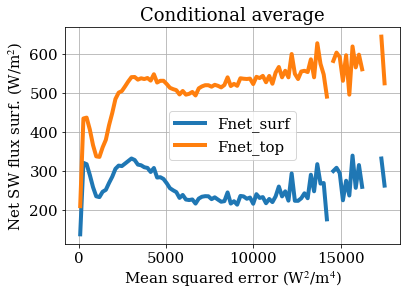

In [131]:
plt.plot(edgTObin(his_mse[1]),Fnet_surf_av[0],label='Fnet_surf')
plt.plot(edgTObin(his_mse[1]),Fnet_top_av[0],label='Fnet_top')
plt.grid()
plt.legend()
plt.xlabel('Mean squared error (W$^{2}$/m$^{4}$)')
plt.ylabel('Net SW flux surf. (W/m$^{2}$)')
plt.title('Conditional average')

In [134]:
zenithA_av = conditional_avg_and_std(his_mse[1],mse,x[:,1])

Text(0.5, 1.0, 'Conditional average')

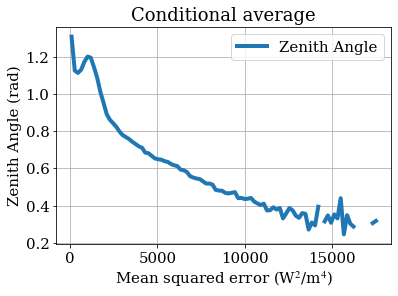

In [136]:
plt.plot(edgTObin(his_mse[1]),zenithA_av[0],label='Zenith Angle')
plt.grid()
plt.legend()
plt.xlabel('Mean squared error (W$^{2}$/m$^{4}$)')
plt.ylabel('Zenith Angle (rad)')
plt.title('Conditional average')

In [137]:
his_zA = np.histogram(x[:,1],bins=100);

In [138]:
flux_zA = conditional_avg_and_std(his_zA[1],x[:,1],y[:,0])

In [141]:
flux_pred_zA = conditional_avg_and_std(his_zA[1],x[:,1],F_pred[:,0])

Text(0.5, 1.0, 'Conditional average')

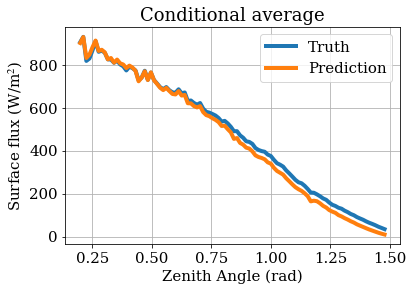

In [143]:
plt.plot(edgTObin(his_zA[1]),flux_zA[0],label='Truth')
plt.plot(edgTObin(his_zA[1]),flux_pred_zA[0],label='Prediction')
plt.grid()
plt.legend()
plt.xlabel('Zenith Angle (rad)')
plt.ylabel('Surface flux (W/m$^{2}$)')
plt.title('Conditional average')